In [1]:
import sys

sys.path.append("../")  # up one level

import altair as alt
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, show_query, select
from update_vars import GCS_FILE_PATH

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Additional Transit Performance Metrics #899

Use the newer recommendations which include performance metrics and ridership experience as outlined in the [UCLA Options for the Future of State Funding for Transit Operations in California](https://escholarship.org/uc/item/2zb6z5rm).  Should try and run/describe all outlined.


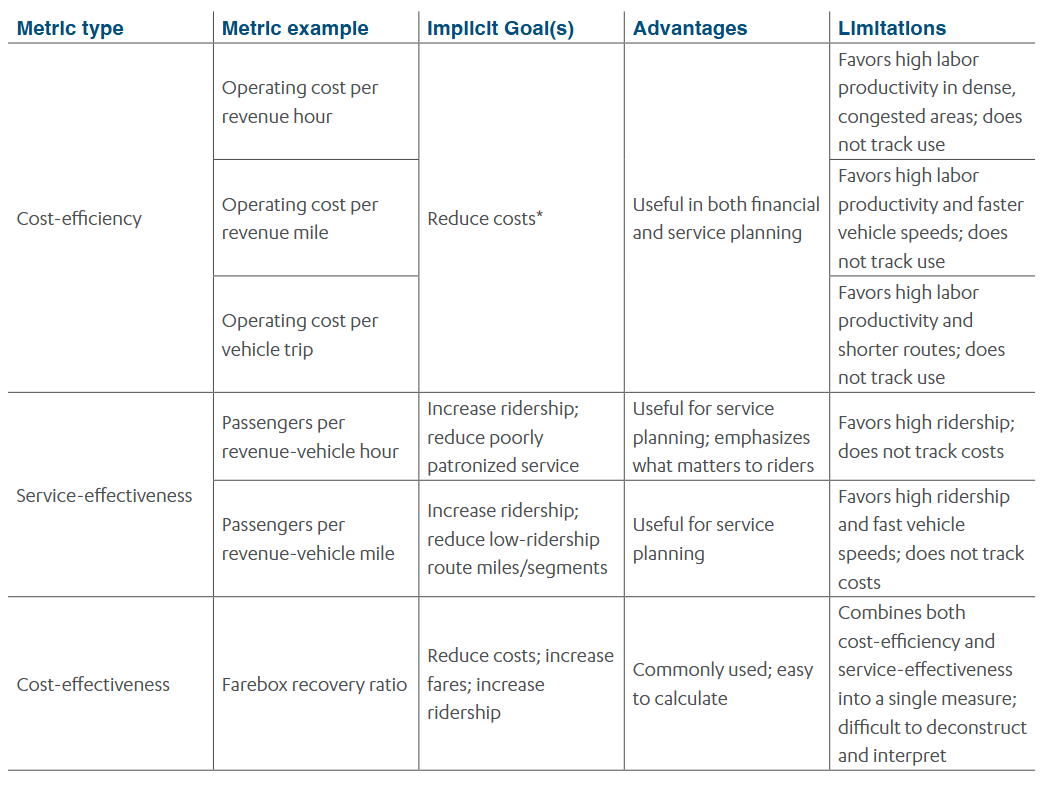

## Data Sources

NTD Products
- [2023 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2023-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"
- [2022 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2022-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-04/2022%20Operating%20Expenses.xlsx"

Warehose Tables
- <s>`dim_monthly_ridership_with_adjustments `</s>, but is only for Monthly reporters
- `dim_annual_service_agencies`, has all type of reporters, VRM, VRH, UPT
- `mart_ntd_annual_reporting.fct_metrics` has it all

## Metrics to calculate

Cost-efficiency metrics
- Operating cost per VRH
- Operating cost per VRM
- Operating cost per trip(?)

Service-effectiveness metrics
- Passengers (upt?) per VRH
- Passengers per VRM

---

## (deprecate?) ~~Read in and Prepare Data using `dim_annual_service_agences` and NTD OpEx report~~

### read in `dim_annual_service_agencies`, 
filter for reporters in CA for 2023

In [ ]:
annnual_service_agencies = (
    tbls.mart_ntd.dim_annual_service_agencies()
    >> filter(_.state == "CA", _.report_year == 2023)
    >> collect()
)
annnual_service_agencies.info()  # 209 rows

### get `NTD IDs` for CA reporters from `annnual_service_agencies`
- will be used to filter the operating expense report

In [ ]:
ca_ntd_ids = annnual_service_agencies["ntd_id"].unique()  # unique ntd ID to filter by

display(
    type(ca_ntd_ids),
    len(ca_ntd_ids),
)

### Read in 2023 Operating Expense data from NTD report

In [ ]:

ntd_2023_opex = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"

col_dict = {"NTD ID": str}

opex_2023 = pd.read_excel(ntd_2023_opex, dtype=(col_dict))
opex_2023.head()  # what is the `total` rows in `operating expense type? is it the the sum of the other categories?
# do i sum `total` with the other categories?

- Confirmed with the [data.transportation.gov interface](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Operating-Expenses-by-Ty/j5uj-anzx/explore/query/SELECT%0A%20%20%60agency%60%2C%0A%20%20%60city%60%2C%0A%20%20%60state%60%2C%0A%20%20%60ntd_id%60%2C%0A%20%20%60organization_type%60%2C%0A%20%20%60reporter_type%60%2C%0A%20%20%60report_year%60%2C%0A%20%20%60uace_code%60%2C%0A%20%20%60uza_name%60%2C%0A%20%20%60primary_uza_population%60%2C%0A%20%20%60agency_voms%60%2C%0A%20%20%60mode%60%2C%0A%20%20%60mode_name%60%2C%0A%20%20%60type_of_service%60%2C%0A%20%20%60mode_voms%60%2C%0A%20%20%60operators_wages%60%2C%0A%20%20%60operators_wages_questionable%60%2C%0A%20%20%60other_salaries_wages%60%2C%0A%20%20%60other_salaries_wages_1%60%2C%0A%20%20%60operator_paid_absences%60%2C%0A%20%20%60operator_paid_absences_1%60%2C%0A%20%20%60other_paid_absences%60%2C%0A%20%20%60other_paid_absences_1%60%2C%0A%20%20%60fringe_benefits%60%2C%0A%20%20%60fringe_benefits_questionable%60%2C%0A%20%20%60services%60%2C%0A%20%20%60services_questionable%60%2C%0A%20%20%60fuel_and_lube%60%2C%0A%20%20%60fuel_and_lube_questionable%60%2C%0A%20%20%60tires%60%2C%0A%20%20%60tires_questionable%60%2C%0A%20%20%60other_materials_supplies%60%2C%0A%20%20%60other_materials_supplies_1%60%2C%0A%20%20%60utilities%60%2C%0A%20%20%60utilities_questionable%60%2C%0A%20%20%60casualty_and_liability%60%2C%0A%20%20%60casualty_and_liability_1%60%2C%0A%20%20%60taxes%60%2C%0A%20%20%60taxes_questionable%60%2C%0A%20%20%60purchased_transportation%60%2C%0A%20%20%60purchased_transportation_1%60%2C%0A%20%20%60miscellaneous%60%2C%0A%20%20%60miscellaneous_questionable%60%2C%0A%20%20%60reduced_reporter_expenses%60%2C%0A%20%20%60reduced_reporter_expenses_1%60%2C%0A%20%20%60total%60%2C%0A%20%20%60total_questionable%60%2C%0A%20%20%60separate_report_amount%60%2C%0A%20%20%60separate_report_amount_1%60%0AWHERE%0A%20%20caseless_one_of%28%60report_year%60%2C%20%222023%22%29%0A%20%20AND%20%28caseless_one_of%28%60state%60%2C%20%22CA%22%29%0A%20%20%20%20%20%20%20%20%20AND%20caseless_one_of%28%0A%20%20%20%20%20%20%20%20%20%20%20%60agency%60%2C%0A%20%20%20%20%20%20%20%20%20%20%20%22Sacramento%20Regional%20Transit%20District%2C%20dba%3A%20Sacramento%20RT%22%0A%20%20%20%20%20%20%20%20%20%29%29/page/filter) to use `total operating expense type = "Total" `

### Filter NTD OpEx data by CA agencies
- aggregate by ntd ID/Agency Name

In [ ]:
keep_cols = [
    "NTD ID",
    "Agency Name",
    "Reporter Type",
    "Operating Expense Type",
    "Total Operating Expenses",
    "Total Operating Expenses (No Funds Reported Separately)",
]

ca_opex_2023 = opex_2023[
    opex_2023["NTD ID"].isin(ca_ntd_ids)  # filter for CA reporters
][
    keep_cols
]  # 1250 rows

ca_opex_2023 = ca_opex_2023[
    ca_opex_2023["Operating Expense Type"] == "Total" #use rows marked "total"
]  # 426 rows

ca_opex_agg = (
    ca_opex_2023.groupby(["NTD ID", "Agency Name"])
    .agg({"Total Operating Expenses": "sum"})  # agg by ntd id and agency
    .reset_index()
)

In [ ]:
display(
    ca_opex_2023.info(),
    ca_opex_agg.info()
)

In [ ]:
ca_opex_2023.head()

In [ ]:
display(
    ca_opex_2023["NTD ID"].nunique(),  # 209, matches unique ntd ids list
    ca_opex_agg["Agency Name"].value_counts().head(),  # LA County has multiple NTD IDs?
    ca_opex_agg[ca_opex_agg["Agency Name"]=="Los Angeles County"]["NTD ID"].value_counts(),
    ca_opex_agg.head(),
)

### Merge `annual_service_agencies` to `ca_open_agg`
- to get annual service agency data, attached with opex data

In [ ]:
print(len(annnual_service_agencies))

keep_cols_2 = [
    "key",
    "report_year",
    "ntd_id",
    "agency",
    "reporter_type",
    "organization_type",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt",
    "Total Operating Expenses",
]


ca_service_agency_opex = annnual_service_agencies.merge(
    ca_opex_agg, how="inner", left_on="ntd_id", right_on="NTD ID"
)[keep_cols_2]

print(ca_service_agency_opex.info())

## (deprecate?) Test of using pulling data from `mart_ntd_annual_reporting.fct_metrics`
- this has opex, upt, vrh and vrm all in one table

### read in `fct_metrics`, filter by CA

In [ ]:
keep_cols_metrics = [
    "ntd_id",
    "agency",
    "organization_type",
    "reporter_type",
    "city",
    "uza_name",
    "agency_voms",
    "mode",
    "type_of_service",
    "report_year",
    "total_operating_expenses",
    "unlinked_passenger_trips",
    "vehicle_revenue_hours",
    "vehicle_revenue_miles",
]

fct_metrics = (
    tbls.mart_ntd_annual_reporting.fct_metrics()
    >> filter(
        _.state == "CA",
        # _.report_year == 2023
    )
    >> collect()
)[keep_cols_metrics]

#fct_metrics.info()  # 852 rows

# grain is agency by mode,tos and report_year

### aggregate `agg_metrics` by agency name and ntd id

In [ ]:
# need to agg by agency, ntd id
agg_metrics = (
    fct_metrics.groupby(
        [
            "ntd_id",
            "agency",
            "report_year",
            #"mode",
            #"type_of_service",
            "organization_type",
            "reporter_type",
            "uza_name",
        ]
    )
    .agg(
        total_opex=("total_operating_expenses", "sum"),
        total_upt=("unlinked_passenger_trips", "sum"),
        total_vrh=("vehicle_revenue_hours", "sum"),
        total_vrm=("vehicle_revenue_miles", "sum"),
    )
    .reset_index()
)

In [ ]:
display(agg_metrics.info(), agg_metrics.head())

### calculate z-scores in `agg_metrics` to find outliers?

In [ ]:
from scipy.stats import zscore

### get zscores from numerical columns

In [ ]:
z_score = agg_metrics[["total_opex", "total_upt", "total_vrh", "total_vrm"]].apply(
    zscore
)

#z_score.describe()

### remove outliers

In [ ]:
threshold = 3
agg_metrics_no_outliers = agg_metrics[(z_score.abs() < threshold).all(axis=1)]

In [ ]:
display(
    "initial data",
    agg_metrics.describe(),  # 328 rows
    "outliers removed",
    agg_metrics_no_outliers.describe(),  # 320 rows
)
# can see that the min/max values of each col were adjusted.

### calculate new performance metrics on `mart_ntd_annual_reporting.fct_metrics`

In [ ]:
calc_dict = {
    "opex_per_vrh": ("total_opex", "total_vrh"),
    "opex_per_vrm": ("total_opex", "total_vrm"),
    "upt_per_vrh": ("total_upt", "total_vrh"),
    "upt_per_vrm": ("total_upt", "total_vrm"),
    "opex_per_upt": ("total_opex", "total_upt"),
}

for new_col, (num, dem) in calc_dict.items():
    agg_metrics_no_outliers[new_col] = (
        agg_metrics_no_outliers[num] / agg_metrics_no_outliers[dem]
    )

#agg_metrics_no_outliers.info()

In [ ]:
agg_metrics_no_outliers.info()

### Export `agg_metrics_no_outliers` to GCS


In [ ]:
#agg_metrics_no_outliers.to_parquet(f"{GCS_FILE_PATH}explore_transit_performance_metrics.parquet")

In [ ]:
#agg_metrics_no_outliers = pd.read_parquet(f"{GCS_FILE_PATH}explore_transit_performance_metrics.parquet")

### melt `agg_metrics_no_outliers`?
- used in later charts but may need to change that

In [ ]:

melt_agg_metrics = agg_metrics_no_outliers.melt(
    id_vars=[
        "ntd_id",
        "agency",
        "report_year",
        "organization_type",
        "reporter_type",
        "uza_name",
    ],
    value_vars=[
        "total_opex",
        "total_upt",
        "total_vrh",
        "total_vrm",
        "opex_per_vrh",
        "opex_per_vrm",
        "upt_per_vrh",
        "upt_per_vrm",
        "opex_per_upt",
    ],
    var_name="categories",
    value_name="metric_amount",
)

#melt_agg_metrics.info()

In [ ]:
melt_agg_metrics.info()

In [ ]:
melt_agg_metrics["categories"].unique()

## Testing data pulled from `mart_ntd_funding_and_expenses`


In [6]:
year_list=["2018","2019","2020","2021","2022","2023"]
col_list=['agency_name',
          'agency_status',
          'city','ntd_id',
          'reporter_type',
          'reporting_module',
          'state',
          'mode',
          'service',
          'primary_uza_name',
          'year',]

In [ ]:
# mart_ntd_funding_and_expenses.fct_operating_and_capital_funding_time_series_operating_total
# alt: mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total
op_total = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total()
    >> select(
        _.agency_name,
        _.agency_status,
        _.city,
        _.mode,
        _.service,
        _.ntd_id,
        _.reporter_type,
        _.reporting_module,
        _.state,
        _.primary_uza_name,
        _.year,
        _.opexp_total,
    )
    >> filter(
        _.state == "CA",
        _.primary_uza_name.str.contains(", CA"),
        _.year.isin(year_list),
        _.opexp_total.notna(),
    )
    >> collect()
)
op_total.info()

In [ ]:
op_total.columns

In [ ]:
op_total.value_counts(subset=["ntd_id","year"]).head(20)

In [ ]:
# mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt
mode_upt = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt()
    >> select(
        _.agency_name,
        _.agency_status,
        _.city,
        _.mode,
        _.service,
        _.ntd_id,
        _.reporter_type,
        _.reporting_module,
        _.state,
        _.primary_uza_name,
        _.year,
        _.upt,
    )
    >> filter(_.state == "CA",
              _.primary_uza_name.str.contains(", CA"),
              _.year.isin(year_list),
              _.upt.notna()
             )
    >> collect()
)
display(
    mode_upt.info(),
    mode_upt.head(10)
)

In [ ]:
# mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh
mode_vrh = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh()
    >> select(
        _.agency_name,
        _.agency_status,
        _.city,
        _.mode,
        _.service,
        _.ntd_id,
        _.reporter_type,
        _.reporting_module,
        _.state,
        _.primary_uza_name,
        _.year,
        _.vrh,
    )
    >> filter(_.state == "CA",
              _.primary_uza_name.str.contains(", CA"),
              _.year.isin(year_list),
              _.vrh.notna()
             )
    >> collect()
)
mode_vrh.info()

In [ ]:
# mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm
mode_vrm = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm()
    >> select(
        _.agency_name,
        _.agency_status,
        _.city,
        _.mode,
        _.service,
        _.ntd_id,
        _.reporter_type,
        _.reporting_module,
        _.state,
        _.primary_uza_name,
        _.year,
        _.vrm,
    )
    >> filter(_.state == "CA",
              _.primary_uza_name.str.contains(", CA"),
              _.year.isin(year_list),
              _.vrm.notna()
             )
    >> collect()
)
mode_vrm.info()

In [ ]:
merge_upt_vrh = mode_upt.merge(
    mode_vrh,
    on= col_list,
    how="left",
    indicator=True,
    
)
display(
    merge_upt_vrh["_merge"].value_counts(),
    merge_upt_vrh.info(),
    merge_upt_vrh.head()
)

In [ ]:
merge_upt_vrh_vrm = merge_upt_vrh.drop(columns="_merge").merge(
    mode_vrm,
    on = col_list,
    how = "left",
    indicator=True
)
display(
    merge_upt_vrh_vrm["_merge"].value_counts(),
    merge_upt_vrh_vrm.info(),
    merge_upt_vrh_vrm.head()
)

In [ ]:
display(
    op_total.columns,
    op_total.shape,
    op_total.head()
)

In [ ]:
merge_opex_upt_vrm_vrh = merge_upt_vrh_vrm.drop(columns="_merge").merge(
    op_total,
    on= col_list,
    how="left",
    indicator=True
)
merge_opex_upt_vrm_vrh["opexp_total"] = merge_opex_upt_vrm_vrh["opexp_total"].fillna(0)

In [ ]:
display(
    merge_opex_upt_vrm_vrh["_merge"].value_counts(),
    merge_opex_upt_vrm_vrh.info(),
    merge_opex_upt_vrm_vrh[merge_opex_upt_vrm_vrh["_merge"]=="left_only"]
)

In [ ]:
op_total[(op_total["ntd_id"]=="90036") & (op_total["mode"]=="MB")]

## Add RTPA data to list
- current aggg_metrics list includes full, reduced, rural reporters.


### test reading in updated `ntd_id_rtpa_crosswalk_all_reporter_types.parquet` crosswalk?


In [ ]:
xwalk_path = "ntd_id_rtpa_crosswalk_all_reporter_types.parquet"

rtpa_ntd_xwalk = pd.read_parquet(f"{GCS_FILE_PATH}{xwalk_path}")

display(
    rtpa_ntd_xwalk.info(),
    rtpa_ntd_xwalk["reporter_type"].value_counts()
)

### (deprecate?) test merging with `agg_metrics_no_outliers` on ntd_id

In [ ]:
rtpa_agg_metrics = agg_metrics_no_outliers.merge(
    rtpa_ntd_xwalk,
    on="ntd_id",
    how="left",
    indicator=True
)

In [ ]:
display(
    len(agg_metrics_no_outliers),
    len(rtpa_ntd_xwalk),
    rtpa_agg_metrics.info(),
    rtpa_agg_metrics["_merge"].value_counts()
)

In [ ]:
rtpa_agg_metrics.head()

## merge RTPA values with `merge_upt_vrm_vrm_opex`

In [ ]:
merge_metrics_rtpa = merge_opex_upt_vrm_vrh.drop(columns="_merge").merge(
    rtpa_ntd_xwalk,
    on=[
        "ntd_id",
        "city",
        "state",
        "agency_name",
        "reporter_type",
        "agency_status"
    ],
    how="left",
    indicator=True
)

display(
    merge_metrics_rtpa["_merge"].value_counts(),
    merge_metrics_rtpa.info(),
    merge_metrics_rtpa.head()
)

### (deprecated) export `rtpa_agg_metrics` gcs


In [ ]:
#rtpa_agg_metrics.to_parquet(f"{GCS_FILE_PATH}explore_transit_performance_metrics.parquet")

## export `merge_metrics_rtpa`
- grain is agency name, mode, service by year.
- includes upt, vrm, vrh, opex for each row above.


In [ ]:
#merge_metrics_rtpa.to_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

## Read in cleaned data

In [2]:
rtpa_agg_metrics = pd.read_parquet(f"{GCS_FILE_PATH}explore_transit_performance_metrics.parquet")

In [3]:
merge_metrics_rtpa = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

## summary stats 

In [ ]:
display(
    rtpa_agg_metrics.info(),
    rtpa_agg_metrics.describe(),
    rtpa_agg_metrics["report_year"].value_counts()
)

In [4]:
display(
    merge_metrics_rtpa.info(),
    merge_metrics_rtpa.describe(),
    merge_metrics_rtpa["year"].value_counts()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2090
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   agency_name       2091 non-null   object  
 1   agency_status     2091 non-null   object  
 2   city              2091 non-null   object  
 3   mode              2091 non-null   object  
 4   service           2091 non-null   object  
 5   ntd_id            2091 non-null   object  
 6   reporter_type     2091 non-null   object  
 7   reporting_module  2091 non-null   object  
 8   state             2091 non-null   object  
 9   primary_uza_name  2091 non-null   object  
 10  year              2091 non-null   object  
 11  upt               2091 non-null   int64   
 12  vrh               2091 non-null   int64   
 13  vrm               2091 non-null   int64   
 14  opexp_total       2091 non-null   float64 
 15  RTPA              2091 non-null   object  
 16  _merge            2091 n

None

,upt,vrh,vrm,opexp_total
count,2.091000e+03,2.091000e+03,2.091000e+03,2.091000e+03
mean,2.660662e+06,1.161680e+05,1.754771e+06,2.223394e+07
std,1.405787e+07,3.934805e+05,5.856907e+06,8.622174e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.887900e+04,5.847500e+03,6.586950e+04,5.853455e+05
50%,7.961300e+04,1.750400e+04,2.583970e+05,1.841343e+06
75%,5.417190e+05,6.606900e+04,1.021278e+06,8.832687e+06
max,2.609022e+08,6.341989e+06,8.378382e+07,1.355086e+09


2019    358
2020    355
2018    348
2021    347
2022    345
2023    338
Name: year, dtype: int64

## aggregate functions with custom `sum_by_group` function
- move this to script


In [7]:
col_list

['agency_name',
 'agency_status',
 'city',
 'ntd_id',
 'reporter_type',
 'reporting_module',
 'state',
 'mode',
 'service',
 'primary_uza_name',
 'year']

In [16]:
merge_metrics_rtpa.columns

Index(['agency_name', 'agency_status', 'city', 'mode', 'service', 'ntd_id',
       'reporter_type', 'reporting_module', 'state', 'primary_uza_name',
       'year', 'upt', 'vrh', 'vrm', 'opexp_total', 'RTPA', '_merge'],
      dtype='object')

In [52]:
def sum_by_group(
    df: pd.DataFrame,
    group_cols: list) -> pd.DataFrame:
    """
    since data is now long to begin with, this replaces old sum_by_group, make_long and assemble_long_df functions.
    """
    grouped_df = df.groupby(group_cols+
                             ["year"]
                           ).agg({
        "upt":"sum",
        "vrm":"sum",
        "vrh":"sum",
        "opexp_total":"sum"
    }
    ).reset_index()
    
    calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
    }

    for new_col, (num, dem) in calc_dict.items():
        grouped_df[new_col] = (
            grouped_df[num] / df[dem]
        )
    
    #get %change back
    #grouped_df = get_percent_change(grouped_df)
    
    #decimal to whole number
    #grouped_df["pct_change_1yr"] = grouped_df["pct_change_1yr"]*100
    
    return grouped_df

In [53]:
agency_cols = ["ntd_id", "agency_name", "RTPA"]
mode_cols = ["mode", "RTPA"]
tos_cols = ["service", "RTPA"]

by_agency_long = sum_by_group(merge_metrics_rtpa, agency_cols)
by_mode_long = sum_by_group(merge_metrics_rtpa, mode_cols)
by_tos_long = sum_by_group(merge_metrics_rtpa, tos_cols)

In [54]:
df_list = [
    by_agency_long,
    by_mode_long,
    by_tos_long
]

for i in df_list:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ntd_id        964 non-null    object 
 1   agency_name   964 non-null    object 
 2   RTPA          964 non-null    object 
 3   year          964 non-null    object 
 4   upt           964 non-null    int64  
 5   vrm           964 non-null    int64  
 6   vrh           964 non-null    int64  
 7   opexp_total   964 non-null    float64
 8   opex_per_vrh  964 non-null    float64
 9   opex_per_vrm  964 non-null    float64
 10  upt_per_vrh   964 non-null    float64
 11  upt_per_vrm   964 non-null    float64
 12  opex_per_upt  964 non-null    float64
dtypes: float64(6), int64(3), object(4)
memory usage: 98.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        -------------- 

### bar chart function

In [37]:
def make_bar(
    data, x_ax, y_ax, color=None, column=None, x_offset=None, row=None, facet=None
):
    # Base chart
    chart = (
        alt.Chart(data)
        .mark_bar()
        .encode(
            x=alt.X(x_ax), 
            y=alt.Y(y_ax, sort='-x'), 
            tooltip=[x_ax, y_ax, "agency_name"])
    )

    # Add color encoding if provided
    if color:
        chart = chart.encode(color=color)

    # Add column facet if provided
    if column:
        chart = chart.encode(column=column)

    if row:
        chart = chart.encode(row=row)

    if x_offset:  # only works in horizontal bar charts
        chart = chart.encode(xOffset=x_offset)

    if facet:
        chart = chart.facet(
            facet=alt.Facet(
                facet,
                title=" ",
            ),
            columns=3,
        )
    # Add title and interactivity
    chart = chart.properties(
        title=f"{x_ax} vs. {y_ax}", width=350, height=150
    ).interactive()

    return chart

### scaterplot function

In [20]:
def make_scatter(data, x_ax, y_ax, color=None, column=None, scale=None):
    chart = (
        alt.Chart(data)
        .mark_point()
        .encode(
            x=alt.X(x_ax)#.scale(type="log")
            , 
            y=alt.Y(y_ax)#.scale(type="log")
            , 
            tooltip=[x_ax, y_ax, "agency_name","year"])
    )

    if color:
        chart = chart.encode(color=color)
    if column:
        chart = chart.encode(columns=column)
    if scale:
        chart = chart.encode(
            x=alt.X(x_ax).scale(type="log"), 
            y=alt.Y(y_ax).scale(type="log"),
        )
    #if x_ax == "total_opex" or y_ax == "total_opex":
    #    chart = chart.encode(
    #        x=alt.X(x_ax).axis(format="$"), 
    #        y=alt.Y(y_ax).axis(format="$"),
    #    )

    chart = chart.properties(
        title=f"{x_ax} vs. {y_ax}", width=500, height=500
    ).interactive()

    return chart + chart.transform_regression(x_ax, y_ax).mark_line()

In [11]:
make_bar(
    rtpa_agg_metrics.sort_values(by="opex_per_vrh", ascending=False),
    x_ax="uza_name:O",
    y_ax="opex_per_vrh:Q",
    # color = "agency",
    #x_offset="report_year",
    # column= "report_year"
)

NameError: name 'make_bar' is not defined

In [ ]:
#melt_agg_metrics["categories"].unique()

In [ ]:
#make_bar(
#    melt_agg_metrics[
#        melt_agg_metrics["categories"].isin(
#            [
                #"opex_per_vrh",
#                "opex_per_vrm",
                #"upt_per_vrh",
                #"upt_per_vrm",
                #"opex_per_upt",
#            ]
#        )
#    ],
#    x_ax="agency:N",
#    y_ax="metric_amount:Q",
    # column="uza_name",
    # row="uza_name:N",
#    color="categories:N",
    # row= "uza_name:N",
    # column="report_year:N",
    # facet = "uza_name"
#)

In [ ]:
# move filter location to the top
from IPython.display import HTML, Image, Markdown, display, display_html

display(
    HTML(
        """<style>form.vega-bindings {  position: absolute;  left: 0px;  top: 0px;}</style>"""
    )
)

In [ ]:
#agg_metrics_no_outliers.columns.to_list()

In [ ]:
#melt_agg_metrics["categories"].unique()

In [ ]:
#melt_agg_metrics.head()

In [ ]:
rtpa_agg_metrics.columns

In [ ]:
# bar chart of agencies `metrics` faceted by uza

# Faceted line chart fund split by FY, by agencies. with drop down selector of RTPA
## actual drop down mechanism
uza_list = list(rtpa_agg_metrics["uza_name"].unique())
uza_dropdown = alt.binding_select(options=uza_list, name="Select UZA")

uza_selector = alt.selection_point(
    fields=["uza_name"], value="Los Angeles--Long Beach--Anaheim, CA", bind=uza_dropdown
)


uza_bar_chart_2 = (
    (
        alt.Chart(
            rtpa_agg_metrics
        )
        .mark_bar(point=True)
        .encode(
            x=alt.X("opex_per_vrh:Q"),
            y=alt.Y("agency_name:N"),
            #xOffset=alt.XOffset("categories:N"),
            yOffset=alt.YOffset("report_year:N"),
            #color=alt.Color("categories:N"),
            # columns="report_year:N",
            tooltip=["categories:N", "opex_per_vrh:Q", "report_year"],
        )
    )
    .add_params(uza_selector)
    .facet(
        facet=alt.Facet(
            "agency_name",
            title=" ",
        ),
        columns=3,
    )
    .resolve_scale(x="independent", y="independent")
    .transform_filter(uza_selector)
)

uza_bar_chart_2

### Cost-efficiency metrics

#### Operating cost per VRH

In [55]:
by_agency_long.head()

,ntd_id,agency_name,RTPA,year,upt,vrm,vrh,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
0,90003,San Francisco Bay Area Rapid Transit District ...,Metropolitan Transportation Commission,2018,129044343,77748993,2211483,653090020.0,217914.587921,14946.219791,43057.838839,2953.230113,49808.573826
1,90003,San Francisco Bay Area Rapid Transit District ...,Metropolitan Transportation Commission,2019,128217031,79665710,2286795,673032280.0,253114.810079,15839.407875,48220.019180,3017.510320,51767.731713
2,90003,San Francisco Bay Area Rapid Transit District ...,Metropolitan Transportation Commission,2020,91006971,71308009,2064392,681983690.0,15610.678005,1129.102723,2083.159086,150.672546,1335.826852
3,90003,San Francisco Bay Area Rapid Transit District ...,Metropolitan Transportation Commission,2021,17839678,50301975,1708631,632582400.0,12693.027269,908.698669,357.960511,25.626530,1016.283153
4,90003,San Francisco Bay Area Rapid Transit District ...,Metropolitan Transportation Commission,2022,38224072,78554914,2486029,685894226.0,32341.296963,2808.394653,1802.342135,156.508504,4723.301491


In [56]:
make_bar(
    by_agency_long,
    x_ax="year",
    y_ax="opex_per_vrh",
    color="RTPA"
)

alt.Chart(...)

In [48]:
alt.Chart(by_agency_long).mark_line(point=True).encode(
    x="year",
    y="vrm",
    color="agency_name",
)

alt.Chart(...)

In [36]:
make_scatter(
    by_agency_long, 
    x_ax="opexp_total", 
    y_ax="vrh", 
    #scale=True,
    color="RTPA:N"
)#.facet(
 #       facet=alt.Facet(
  #          "reporter_type",
   #         title=" ",
    #    ),
     #   columns=2,
    #)

alt.LayerChart(...)

#### Operating cost per VRM

In [ ]:
make_scatter(rtpa_agg_metrics, "total_opex", "total_vrm",color="reporter_type_x:N",scale=True).facet(
        facet=alt.Facet(
            "reporter_type_x",
            title=" ",
        ),
        columns=2,
    )

In [ ]:
make_scatter(rtpa_agg_metrics, "total_opex", "total_vrm", color="reporter_type_x",scale=True)

#### Operating cost per trip(?) (upt or like, gtfs trip)

In [ ]:
make_scatter(rtpa_agg_metrics, "total_opex", "total_upt", color="organization_type:N", scale=True).facet(
        facet=alt.Facet(
            "report_year",
            title=" ",
        ),
        columns=2,
    )

### Service-effectiveness metrics

#### Passengers (upt?) per VRH

In [ ]:
make_scatter(rtpa_agg_metrics, "total_upt", "total_vrh", color="report_year:N",scale=True).facet(
        facet=alt.Facet(
            "report_year",
            title=" ",
        ),
        columns=2,
    )

In [ ]:
make_scatter(rtpa_agg_metrics, "total_upt", "total_vrh", color="RTPA:N",scale=True).facet(
        facet=alt.Facet(
            "report_year",
            title=" ",
        ),
        columns=2,
    )

#### Passengers per VRM

In [ ]:
make_scatter(rtpa_agg_metrics, "total_upt", "total_vrm", color="reporter_type_x",scale=True).facet(
        facet=alt.Facet(
            "report_year",
            title=" ",
        ),
        columns=2,
    )

#### other

In [ ]:
make_scatter(rtpa_agg_metrics, "reporter_type_x", "opex_per_vrm", color = "uza_name",scale=True).facet(
        facet=alt.Facet(
            "report_year",
            title=" ",
        ),
        columns=2,
    )